In [1]:
from scipy.stats import wishart, multivariate_normal as normal
from scipy.special import gamma,gammaln
from numpy.linalg import det,inv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

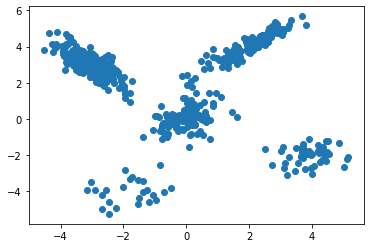

In [2]:
nsample = 500
c=5
d=2
pi = [0.4, 0.25, 0.2, 0.1, 0.05]
mu = [[-3, 3], [2, 4], [0, 0], [4, -2], [-2, -4]]
cov = [[[.4, -.4], [-.4, .6]],\
        [[.7, .6], [.6, .6]],\
        [[.3, .2], [.2, .5]],\
        [[.3, 0], [0, .3]],\
        [[.5, .1], [.1, .5]]]

X = []
for i in range(c):
    num = int(pi[i] * nsample)
    for j in range(num):
        X.append(normal.rvs(mu[i], cov[i]))

X = np.array(X)

plt.scatter(X[:,0],X[:,1])
plt.show()

In [3]:
class iGMM():
    def __init__(self, X, alpha, m0, beta0, W0, nu0):
        self.eps = np.finfo(np.float).eps
        
        # Hyper Parameters
        self.alpha = alpha
        self.m0 = m0
        self.beta0 = beta0
        self.W0 = W0
        self.nu0 = nu0
        
        # Data
        self.X = X
        self.N_data, self.D = X.shape
        

        # Parameters
        
        self.K = 1
        self.N = np.array([self.N_data])
        self.z = np.zeros(self.N_data,dtype=np.int32)
        self.mu = np.tile(m0,(self.K,1))
        self.L = np.tile(W0, (self.K,1,1))
        
        self.x_bar = np.zeros([self.K,self.D])
        self.S = np.zeros([self.K,self.D,self.D])
        self.beta = beta0*np.ones(self.K)
        self.m = np.tile(np.mean(X,axis=0),(self.K,1))
        self.nu = nu0*np.ones(self.K)
        self.W = np.tile(W0, (self.K,1,1))
        
        
    def update_x_bar(self):
        for k in range(self.K):
            self.x_bar[k,:] = np.mean(self.X[np.where(self.z==k)[0], :], axis=0) 
            
    def update_S(self):
        for k in range(self.K):
            X_center = X[np.where(self.z==k)[0], :] - self.x_bar[k]
            self.S[k,:,:] = np.dot(X_center.T, X_center)

    def update_beta(self):
        self.beta = self.beta0 + self.N
                                  
    def update_m(self):
        self.m = 1/self.beta.reshape([-1,1])*(self.beta0*self.m0.reshape([1,-1])+self.N.reshape([-1,1])*self.x_bar)
        
    def update_nu(self):
        self.nu = self.nu0 + self.N
    
    def update_W(self):
        for k in range(self.K):
            self.W[k,:,:] = inv(inv(self.W0) + self.S[k,:,:] \
                    + self.beta0*self.N[k]/(self.beta[k]) \
                    * np.outer((self.x_bar[k]-self.m0), (self.x_bar[k]-self.m0)))
            
        
    def est_post(self, max_iter=300):
        frame_mu = []
        frame_Sigma = []
        frame_idx = []
        frame_log_post_prob = []
        frame_K = []
        
        for _ in tqdm(range(max_iter)):
            for i in range(self.N_data):
                self.sampling_class(i)
            self.sampling_params()
            
            
            frame_mu.append(self.m.copy())
            frame_Sigma.append(inv(self.L))
            frame_idx.append(self.z.copy())
            
            frame_log_post_prob.append(self.calc_log_post_prob())
            frame_K.append(self.K)
            
        return frame_mu, frame_Sigma, frame_idx, frame_log_post_prob ,frame_K
    
            
    def sampling_class(self, i):
        z_i = self.z[i]
        self.N[z_i] -=1
        if self.N[z_i]==0:
            self.remove_class(z_i)
        
        p = np.zeros(self.K+1)
        for k in range(self.K):
            p[k] = self.N[k]*normal.pdf(X[i,:],self.mu[k], inv(self.L[k]))

        W_K = inv(inv(self.W0) + self.beta0/(self.beta0+1)\
                    * np.outer((X[i,:]-self.m0), (self.X[i,:]-self.m0)))
        
        p[self.K] = self.alpha * (self.beta0/((1+self.beta0)*np.pi))**(self.D/2) \
                    * det(W_K)**((self.nu0+1)/2) * gamma((self.nu0+1)/2) \
                    / (det(self.W0)**(self.nu0/2)  *  gamma((self.nu0+1-self.D)/2))

        k_sampled = np.random.choice(a=range(self.K+1), size=1, p=p/np.sum(p))
        if k_sampled != self.K:
            self.z[i] = k_sampled
            self.N[k_sampled] += 1
            return
        else:
            self.z[i] = self.K
            self.add_class(i)
            
            
    def remove_class(self,k):
        self.K -= 1
        for j in range(self.N_data):
            if self.z[j] > k:
                self.z[j] -= 1
        self.N = np.delete(self.N, obj=k, axis=0)
        self.x_bar = np.delete(self.x_bar, obj=k, axis=0)
        self.S = np.delete(self.S, obj=k, axis=0)
        self.beta = np.delete(self.beta, obj=k, axis=0)
        self.m = np.delete(self.m, obj=k, axis=0)
        self.nu = np.delete(self.nu, obj=k, axis=0)
        self.W = np.delete(self.W, obj=k, axis=0)

        
    def add_class(self,i):
        self.K += 1
        self.N = np.concatenate((self.N, np.array([1])))
        
        self.x_bar = np.concatenate((self.x_bar,X[i,:].reshape(1,-1)))
        self.S = np.concatenate((self.S, np.zeros([2,2])[np.newaxis,:,:]))
        self.beta = np.concatenate((self.beta, self.beta0+1))
        self.m = np.concatenate((self.m, ((self.beta0*self.m0 + self.X[i,:])/(self.beta0 + 1))[np.newaxis,:]))
        self.nu = np.concatenate((self.nu, self.nu0+1))
        W_K = inv(inv(self.W0) + self.beta0/(self.beta0+1) \
                        * np.outer((X[i,:]-self.m0), (self.X[i,:]-self.m0)))

        self.W = np.concatenate((self.W, W_K[np.newaxis,:,:]))
        
        self.L = np.concatenate((self.L, wishart.rvs(self.nu[-1], W_K)[np.newaxis,:,:]))
        self.mu = np.concatenate((self.mu, normal.rvs(self.m[-1], inv(self.beta[-1]*self.L[-1,:,:]))[np.newaxis,:]))

            
    def sampling_params(self):
        self.update_x_bar()
        self.update_S()
        self.update_beta()
        self.update_m()
        self.update_nu()
        self.update_W()
        for k in range(self.K):
            self.L[k,:,:] = wishart.rvs(self.nu[k], self.W[k,:,:])
            self.mu[k,:] = normal.rvs(self.m[k,:], inv(self.beta[k]*self.L[k,:,:]))

    
    def calc_log_post_prob(self):
        log_p = self.K*np.log(self.alpha)
        log_p -= gammaln(self.alpha+self.N_data-1)
        
        
        for k in range(self.K):
            if self.N[k] > 1:
                log_p += gammaln(self.N[k]-1)
            log_p += (self.D/2)*np.log(self.beta0/self.beta[k]/np.pi**self.N[k])
            log_p += (self.nu[k])/2 * np.log(det(self.W[k,:,:]))
            log_p -= (self.nu0)/2 * np.log(det(self.W0))
            for d in range(self.D):
                log_p += gammaln((self.nu[k]-d)/2)
                log_p -= gammaln((self.nu0-d)/2)
            
            
        return log_p

In [4]:
D = 2
alpha = np.ones([1])*1
m0 = np.zeros(D)
beta0 = np.array([1])/3
W0 = np.eye(2)*0.1
nu0 = np.array([15])

igmm = iGMM(X, alpha, m0, beta0, W0, nu0)

max_iter = 100
frame_mu, frame_Sigma, frame_idx, frame_log_post_prob ,frame_K  = igmm.est_post(max_iter)

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


<IPython.core.display.Javascript object>


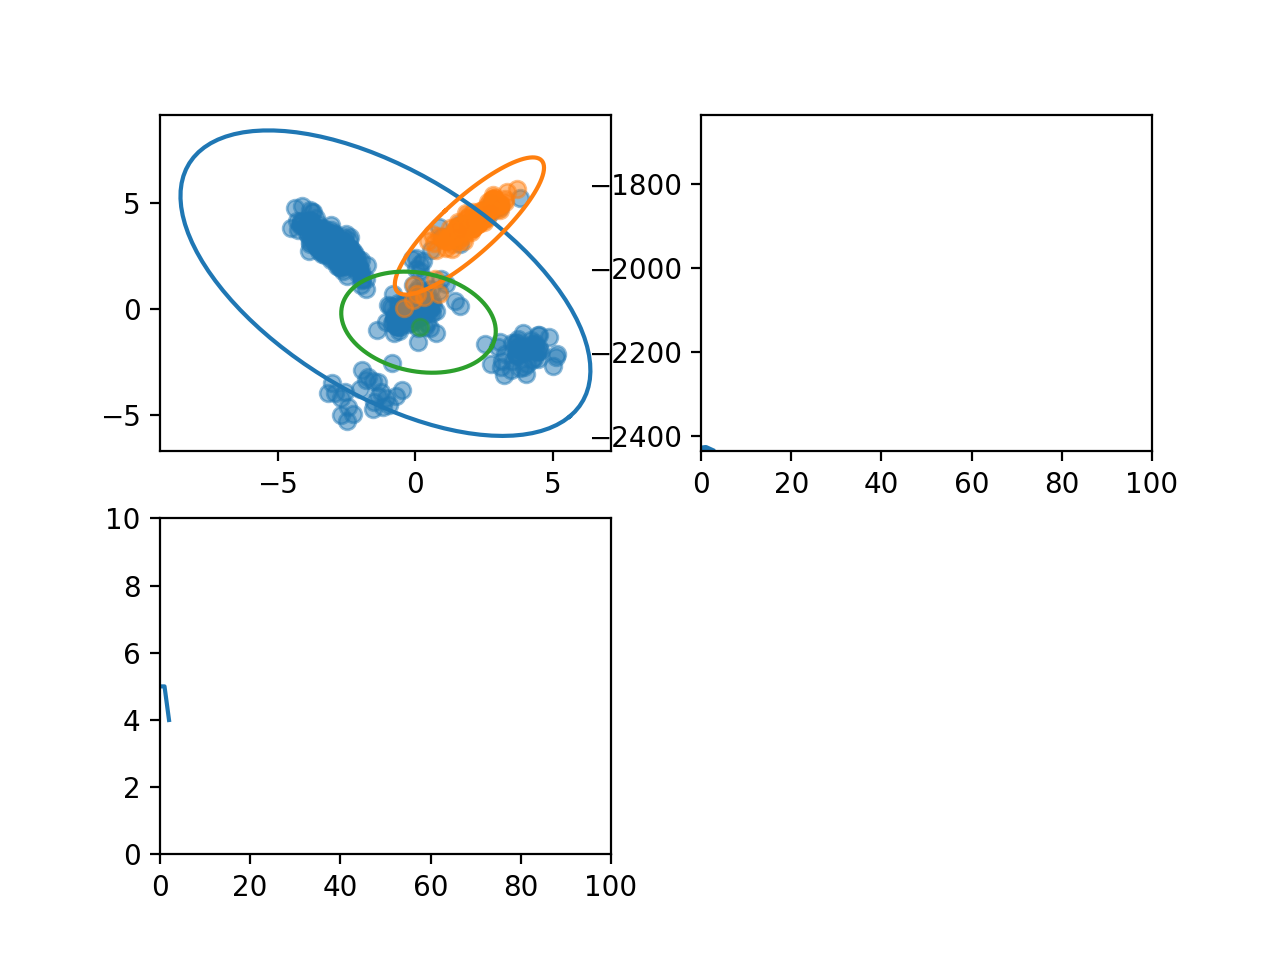

In [5]:
%matplotlib nbagg

def ellipse(mu,Sigma,n_sig=3):
    mu = mu.reshape([2,1])
    V,W = np.linalg.eig(Sigma)
    ax_x,ax_y = V**(1/2)
    
    t = np.linspace(0,2*np.pi,100)
    xy = np.vstack([ax_x*n_sig*np.cos(t),ax_y*n_sig*np.sin(t)])
    
    xy = np.dot(W,xy)
    xy = xy + mu
    return xy[0],xy[1]
    

def update_graph(frame, ax1, ax2, ax3, max_iter, X, frame_idx, frame_mu, frame_Sigma, frame_log_post_prob, frame_K, n_sig=3):
    ax1.cla()
    ax2.cla()
    ax3.cla()
    list_idx = frame_idx[frame]
    list_mu = frame_mu[frame]
    list_Sigma = frame_Sigma[frame]
    K = len(list_mu)

    for k in range(K):
        idx = np.where(list_idx==k)
        ax1.scatter(X[idx,0],X[idx,1],alpha=0.5)
        ell_x,ell_y = ellipse(list_mu[k],list_Sigma[k],n_sig)
        ax1.plot(ell_x, ell_y)
#         ax1.set_xlim(np.min(X[:,0]), np.max(X[:,0]))
#         ax1.set_ylim(np.min(X[:,1]), np.max(X[:,1]))

        
    ax2.plot(frame_log_post_prob[:frame], linewidth = 3)
    ax2.set_xlim(0, max_iter)
    ylim_max = max(frame_log_post_prob)
    ylim_min = min(frame_log_post_prob)
    ax2.set_ylim(ylim_min, ylim_max+10)
    
    ax3.plot(frame_K[:frame])
    ax3.set_xlim(0, max_iter)
    ax3.set_ylim(0, max(frame_K))

n_sig = 3
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

ani = FuncAnimation(fig, update_graph, fargs = (ax1,ax2,ax3,max_iter,X,frame_idx,frame_mu,frame_Sigma,frame_log_post_prob, frame_K, n_sig), \
    interval = 200, frames = max_iter)
# ani.save("vb-gmm.gif", writer="imagemagick")